# 0.0 Solution Planning (IOT)

## Input 
1. Business Issue
    - Select the most valuable customers for a loyalty program.
2. Dataset
    - E-commerce sels online, during one year period.

## Output
1. Recommendation list of customers the should be in Loyalty program.
- List: client_id | is_insider

2. Report with business answers:
- 1. Who are eligible to participate the Insiders Program?
- 2. How many customers will be part of the group?
- 3. What are the mainly characteristics of there customers?
- 4. What is the % of revenue coming of these customers?
- 5. What's the revenue expectation for this group next month?
- 6. What are the conditions for someone to be eligible for insiders?
- 7. What are the conditions for someone to be removed from insiders?
- 8. What is the guarantee that the Insiders program is best than the remaining base?
- 9. What actions the marketing team can do for increasing the revenue?

## Tasks

1. Report with business answers:
- 1. Who are eligible to participate the Insiders Program?
    - What is being eligible? What are the most valuable customers?
        - Cost:
        - Buy Experience
        - Basket Size
        - High buy likely
        - Low devolution rate.
- 2. How many customers will be part of the group?
    - Total number of customers
    - % of Insiders Group
- 3. What are the mainly characteristics of there customers?
    - Write customers characteristics:
        - Age
        - Localization
    - Write consuming characteristics:
        - Clustering Features

- 4. What is the % of revenue coming of these customers?
    - Total Revenue vs Insiders Group Revenue
- 5. What's the revenue expectation for this group next month?
    - Insiders Group LTV
    - Cohort Analysis 

- 6. What are the conditions for someone to be eligible for insiders?
    - Define the Insiders update periodicity  
    - The customers needs to be lookalike someone of the Insiders group.


- 7. What are the conditions for someone to be removed from insiders?
    - Define the Insiders update periodicity  
    - The customers needs to be unlookalike someone of the Insiders group.   


- 8. What is the guarantee that the Insiders program is best than the remaining base?
    - A/B test
    - A/B Bayesian test
    - Hypotesis Test


- 9. What actions the marketing team can do for increasing the revenue?
    - Discount
    - New products
    - New employees

## Solutions Benchmark
1. Desk Research

## 0.1 Import libraries

In [157]:

from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
import pandas as pd
import seaborn as sns
import numpy as np
import re
from pandas_profiling import ProfileReport
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn import cluster as c 
from sklearn import metrics as m
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.gridspec as gridspec
from plotly import express as px
import pylab 
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy as hc 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline


plt.rcParams["figure.figsize"] = (15,8)


## 0.2 Load dataset

In [79]:
df0 = pd.read_csv('data.csv', encoding='latin1')
df0.columns=df0.columns.str.lower()
df0.head(3)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


# 1.0 Data Description

In [80]:
df1=df0.copy()

## 1.1 data dimensions

In [81]:
df1.shape

(541909, 8)

## 1.2 N/As treatment

In [82]:
df1.isna().sum()/len(df1)

invoiceno      0.000000
stockcode      0.000000
description    0.002683
quantity       0.000000
invoicedate    0.000000
unitprice      0.000000
customerid     0.249267
country        0.000000
dtype: float64

In [83]:
df_missing=df1[df1['customerid'].isna()]
df_not_missing=df1[~df1['customerid'].isna()]
df_missing[df_missing['invoiceno'].isin(df_not_missing['invoiceno'])].shape

(0, 8)

In [84]:
# create reference
df_backup = pd.DataFrame( df_missing['invoiceno'].drop_duplicates())
df_backup['customerid']=np.arange(80000, 80000+len( df_backup ), 1)

# merge original with reference datafarme
df1 = df1.merge(df_backup, on='invoiceno', how='left')

#coalesce
df1['customerid']=df1['customerid_x'].combine_first( df1['customerid_y'])

#drop extra columns
df1 = df1.drop( columns=['customerid_x','customerid_y'], axis=1)

df1.isna().sum()

invoiceno         0
stockcode         0
description    1454
quantity          0
invoicedate       0
unitprice         0
country           0
customerid        0
dtype: int64

In [85]:
df1.isna().sum()

invoiceno         0
stockcode         0
description    1454
quantity          0
invoicedate       0
unitprice         0
country           0
customerid        0
dtype: int64

## 1.3 data types treatment

In [86]:
df1.dtypes

invoiceno       object
stockcode       object
description     object
quantity         int64
invoicedate     object
unitprice      float64
country         object
customerid     float64
dtype: object

In [87]:
df1.head(3)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,17850.0


In [88]:
df1['invoicedate']=df1['invoicedate'].str.split(expand=True)[0]
df1.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010,3.39,United Kingdom,17850.0


In [89]:
#invoice date
df1['invoicedate'] = pd.to_datetime( df1['invoicedate'], format="%m/%d/%Y",errors='coerce')

df1['customerid']=df1['customerid'].astype(int)
df1.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,country,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


## 1.4 descriptive statistics - numeric

In [90]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [91]:
pd.concat([num_attributes.describe(percentiles=[.5]).T,num_attributes.agg(['skew','kurtosis']).T],axis=1)

,count,mean,std,min,50%,max,skew,kurtosis
quantity,541909.0,9.552250,218.081158,-80995.00,3.00,80995.0,-0.264076,119769.160031
unitprice,541909.0,4.611114,96.759853,-11062.06,2.08,38970.0,186.506972,59005.719097
customerid,541909.0,31894.123997,28863.991573,12346.00,16249.00,83709.0,1.151555,-0.657583


### 1.4.1 quantity

In [92]:
#how many negative quantities there is?

aux0=num_attributes[num_attributes['quantity']<0]
print(aux0['quantity'].head(3))
print(f"There is {len(aux0)/len(num_attributes)} negative quantity")
# Because it has less than  2% of negative quantity, in this Crisp-DM circle all negatives prices will be dropped


141    -1
154    -1
235   -12
Name: quantity, dtype: int64
There is 0.019604767590130447 negative quantity


### 1.4.2 unit price

In [93]:
# inspect unitprice equal zero
aux0=num_attributes[num_attributes['unitprice']==0]
print(aux0['unitprice'].head(3))
print(f"There is {len(aux0)/len(num_attributes)} 0 quantity")

# Because it has less than  1% of negative unit price, in this Crisp-DM circle all negatives prices will be dropped

622     0.0
1970    0.0
1971    0.0
Name: unitprice, dtype: float64
There is 0.004641000610803659 0 quantity


## 1.5 descriptive statistics - categoric

In [94]:
cat_attributes.head(1)

,invoiceno,stockcode,description,country,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,17850


### 1.5.1 Invoice

In [95]:
#How many invoices with letters there is?

aux0=cat_attributes[cat_attributes['invoiceno'].str.contains('[^0-9]+', na=False)]
print(aux0['invoiceno'].head(3))
print(f"There is {len(aux0)/len(cat_attributes)} invoices with letters")

# Because it has only 2% of stock codes with letters-only, in this Crisp-DM circle it will be dropped


141    C536379
154    C536383
235    C536391
Name: invoiceno, dtype: object
There is 0.017144944999990773 invoices with letters


### 1.5.2 stockcodes

In [96]:
#How many stockcodes with letters there is?

aux0=cat_attributes[cat_attributes['stockcode'].str.contains('[^0-9]+', na=False)]
print(aux0['stockcode'].head(3), len(aux0)/len(cat_attributes))

aux0=cat_attributes[~cat_attributes['stockcode'].str.contains('[0-9]+', na=False)]
print(aux0['stockcode'].head(3), len(aux0)/len(cat_attributes))
print(aux0['stockcode'].unique())

# Because it has only 0,4% of stock codes with letters-only, in this Crisp-DM circle it will be dropped

0    85123A
2    84406B
3    84029G
Name: stockcode, dtype: object 0.10125869841615474
45     POST
141       D
386    POST
Name: stockcode, dtype: object 0.00515953785598689
['POST' 'D' 'DOT' 'M' 'BANK CHARGES' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY'
 'DCGSSGIRL' 'PADS' 'B' 'CRUK']


In [97]:
# Description
df1['description'].head()

# For this circle, description variable will be dropped

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: description, dtype: object

In [98]:
# Country
print(len(df1['country'].unique()), "\n", df1['country'].unique(),  
df1['country'].value_counts(normalize=True).head())

# for this circle, "Unspecified" and "European Community" will be dropped, for two reasons:
# It has very small data representativiness and through "European Community" its not possible to know the specific country

38 
 ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA'] United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64


# 2.0 Feature Filtering/Cleaning

In [99]:
df2=df1.copy()

In [100]:
 # ----------------------  Numerical attributes ----------------
 # purhcases df and returns df
returns = df2.loc[df2['quantity'] < 0, :]
purchases = df2.loc[df2['quantity'] >= 0, :]


print(df2.shape)


#drop invoices with only letters
df2=df2[~df2['invoiceno'].str.contains('[^0-9]+', na=False)]
print(df2.shape)

#filter only stockcodes with numbers
#df2=df2[df2['stockcode'].str.contains('[0-9]+', na=False)]
print(df2.shape)


# ------------------ Categorical attributes -------------------
# drop description
df2 = df2.drop( columns='description', axis=1 )

# drop "unspecifiec" and "european communoty" countries -  
df2 = df2[~df2['country'].isin( ["European Community",'Unspecified' ] ) ]



df2.head()
print(df0.shape, df2.shape)

(541909, 8)
(532618, 8)
(532618, 8)
(541909, 8) (532112, 7)


# 3.0 Feature Engineering

In [101]:
# data reference
df3=df2.copy()

## 3.1 Feature Creation

In [102]:
df_ref=df3[['customerid']].drop_duplicates(ignore_index=True)
df_ref.head(3)

,customerid
0,17850
1,13047
2,12583


### 3.1.1 profit (gross revenue - gross outgoins)

In [103]:
# gross revenue
purchases['gross_revenue'] = purchases['quantity'] * purchases['unitprice']
df_monetary = purchases[['customerid', 'gross_revenue']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_monetary,on='customerid',how='left').fillna(0)
print(df_ref.isna().sum())


# gross outgoings
returns['gross_returns'] = returns['quantity'] * returns['unitprice']*-1
df_returns = returns[['customerid', 'gross_returns']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_returns,on='customerid',how='left').fillna(0)
print(df_ref.isna().sum())


df_ref.head()
df_ref['profit'] = df_ref['gross_revenue']-df_ref['gross_returns']
df_ref=df_ref.drop(['gross_revenue','gross_returns'], axis=1)
df_ref.head()

customerid       0
gross_revenue    0
dtype: int64
customerid       0
gross_revenue    0
gross_returns    0
dtype: int64


,customerid,profit
0,17850,5288.63
1,13047,3079.10
2,12583,7187.34
3,13748,948.25
4,15100,635.10


### 3.1.2 recency

In [104]:
#recency
df_recency = purchases.groupby( 'customerid').max().reset_index()
df_recency['recencydays'] = ( purchases['invoicedate'].max() - df_recency['invoicedate'] ).dt.days
df_recency= df_recency[['customerid','recencydays']].copy()
df_ref=df_ref.merge(df_recency, how='left', on='customerid')

print(df_ref.isna().sum())
df_ref.head()

customerid        0
profit            0
recencydays    1336
dtype: int64


,customerid,profit,recencydays
0,17850,5288.63,372.0
1,13047,3079.10,31.0
2,12583,7187.34,2.0
3,13748,948.25,95.0
4,15100,635.10,333.0


### 3.1.3 quantity of items kept

In [105]:
# quantity of products purchased
df_freq = purchases[['customerid', 'quantity']].drop_duplicates().groupby( 'customerid' ).sum().reset_index().rename( columns={'quantity':'qtd_items'})
df_ref = pd.merge( df_ref, df_freq, on='customerid', how='left' ).fillna(0)
print(df_ref.isna().sum())

### quantity of items returned
# quantity of products purchased
df_freq = returns[['customerid', 'quantity']].drop_duplicates().groupby( 'customerid' ).sum().reset_index().rename( columns={'quantity':'qtd_items_return'})
df_freq['qtd_items_return'] = df_freq['qtd_items_return']*-1
df_ref = pd.merge( df_ref, df_freq, on='customerid', how='left' ).fillna(0)
df_ref.isna().sum()
print(df_ref.isna().sum())


### qtd items kept
# quantity of products purchased
df_ref['items_kept'] = df_ref['qtd_items']-df_ref['qtd_items_return']
df_ref=df_ref.drop(['qtd_items','qtd_items_return'], axis=1)
df_ref.head()


customerid     0
profit         0
recencydays    0
qtd_items      0
dtype: int64
customerid          0
profit              0
recencydays         0
qtd_items           0
qtd_items_return    0
dtype: int64


,customerid,profit,recencydays,items_kept
0,17850,5288.63,372.0,14.0
1,13047,3079.10,31.0,126.0
2,12583,7187.34,2.0,1519.0
3,13748,948.25,95.0,169.0
4,15100,635.10,333.0,26.0


### 3.1.4 avg ticket

In [106]:
 # Avg Ticket
df_ref['avg_ticket']=df_ref['profit']/df_ref['items_kept']
df_ref['avg_ticket']=df_ref['avg_ticket'].replace([np.inf, -np.inf], 0) 
df_ref.isna().sum()

customerid     0
profit         0
recencydays    0
items_kept     0
avg_ticket     9
dtype: int64

### 3.1.5 avg recency days

In [107]:
# average recency days
df_aux = df2[df2['customerid']==17850][['customerid','invoicedate']].drop_duplicates().sort_values(['customerid','invoicedate'],ascending=[False,False]).head()
df_aux['next_customer_id'] = df_aux['customerid'].shift()
df_aux['previous_date'] = df_aux['invoicedate'].shift()

df_aux['avg_recencydays'] = df_aux.apply( lambda x: ( x['invoicedate'] - x['previous_date']).days if x['customerid']==x['next_customer_id'] else np.nan, axis=1)

df_aux= df_aux.drop( ['invoicedate','next_customer_id', 'previous_date'], axis=1).dropna()

# averagy recency
df_avg_recency_days = df_aux.groupby( 'customerid' ).mean().reset_index()

df_ref.merge(df_avg_recency_days, on='customerid', how='left')
print(df_ref.isna().sum())
df_avg_recency_days.head()

customerid     0
profit         0
recencydays    0
items_kept     0
avg_ticket     9
dtype: int64


,customerid,avg_recencydays
0,17850,-1.0


### 3.1.6 frequency

In [108]:
# frequency

df_aux = ( df2[['customerid', 'invoiceno', 'invoicedate']].drop_duplicates()
                                                        .groupby('customerid')
                                                        .agg( max_ = ('invoicedate', 'max'),
                                                            min_= ('invoicedate', 'min'),
                                                            days_= ('invoicedate', lambda x: (( x.max() - x.min()).days ) +1 ),
                                                            buy_ = ('invoiceno', 'count')).reset_index()
)

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_ref= df_ref.merge(df_aux[['customerid','frequency']], on='customerid', how='left')

df_ref.isna().sum()

customerid     0
profit         0
recencydays    0
items_kept     0
avg_ticket     9
frequency      0
dtype: int64

### 3.1.7 basket size

In [109]:
# basket size
df_aux = ( purchases.groupby('customerid').agg( n_purchases = ('invoiceno','nunique'), n_products = ('quantity','sum'))
                                            .reset_index()
)

#calculation
df_aux['avg_basket_size'] = df_aux['n_purchases'] / df_aux['n_products']
df_ref = df_ref.merge( df_aux[['customerid', 'avg_basket_size']], how='left', on='customerid')

print(df_ref.isna().sum())

df_ref.head()

customerid            0
profit                0
recencydays           0
items_kept            0
avg_ticket            9
frequency             0
avg_basket_size    1336
dtype: int64


,customerid,profit,recencydays,items_kept,avg_ticket,frequency,avg_basket_size
0,17850,5288.63,372.0,14.0,377.759286,17.000000,0.019619
1,13047,3079.10,31.0,126.0,24.437302,0.029155,0.007189
2,12583,7187.34,2.0,1519.0,4.731626,0.040323,0.002964
3,13748,948.25,95.0,169.0,5.610947,0.017921,0.011390
4,15100,635.10,333.0,26.0,24.426923,0.073171,0.037500


# 4.0 EDA (Exploratory Data Analysis)

In [110]:
df4=df_ref.dropna().copy()
df4.head()

,customerid,profit,recencydays,items_kept,avg_ticket,frequency,avg_basket_size
0,17850,5288.63,372.0,14.0,377.759286,17.000000,0.019619
1,13047,3079.10,31.0,126.0,24.437302,0.029155,0.007189
2,12583,7187.34,2.0,1519.0,4.731626,0.040323,0.002964
3,13748,948.25,95.0,169.0,5.610947,0.017921,0.011390
4,15100,635.10,333.0,26.0,24.426923,0.073171,0.037500


## 4.1 Univariate Analysis

In [111]:
num_attributes1 = df4.select_dtypes(include=['int64','float64','int32'])


In [112]:
pd.concat([num_attributes1.describe(percentiles=[.5]).T,num_attributes1.agg(['skew','kurtosis']).T],axis=1)

,count,mean,std,min,50%,max,skew,kurtosis
customerid,6509.0,37625.057152,31453.537890,12347.000000,16794.000000,83709.00,0.691749,-1.511262
profit,6509.0,1543.808587,6878.138331,-1165.300000,490.600000,279489.02,25.156003,838.356568
recencydays,6509.0,122.783223,112.794073,0.000000,78.000000,373.00,0.733018,-0.770568
items_kept,6509.0,207.322477,861.369915,-2887.000000,82.000000,37684.00,21.623155,696.611644
avg_ticket,6509.0,14.361570,190.239544,-258.544286,6.087156,13541.33,58.783179,3992.356958
frequency,6509.0,0.602991,0.537741,0.005450,1.000000,17.00,4.350205,131.743947
avg_basket_size,6509.0,0.081656,0.222580,0.000025,0.007651,1.00,3.450565,10.957528


### 4.1.1 profit - inspect extreme values

In [113]:
df4.sort_values('profit', ascending=False).head()

,customerid,profit,recencydays,items_kept,avg_ticket,frequency,avg_basket_size
1083,14646,279489.02,1.0,15225.0,18.357243,0.209040,0.000375
531,18102,256438.49,0.0,12871.0,19.923743,0.163043,0.000936
463,17450,187482.17,8.0,37684.0,4.975113,0.127778,0.000657
66,14911,132572.62,1.0,2639.0,50.235930,0.538874,0.002496
1239,12415,123725.45,24.0,9563.0,12.937933,0.066879,0.000270


In [114]:
#inspect higher profit customer
df3[df3['customerid']==14646].head(10)

,invoiceno,stockcode,quantity,invoicedate,unitprice,country,customerid
37952,539491,21981,12,2010-12-20,0.29,Netherlands,14646
37953,539491,21986,12,2010-12-20,0.29,Netherlands,14646
37954,539491,22720,2,2010-12-20,4.95,Netherlands,14646
37955,539491,21931,1,2010-12-20,1.95,Netherlands,14646
37956,539491,22613,2,2010-12-20,0.85,Netherlands,14646
37957,539491,20751,1,2010-12-20,2.10,Netherlands,14646
37958,539491,21246,2,2010-12-20,4.95,Netherlands,14646
37959,539491,22960,1,2010-12-20,4.25,Netherlands,14646
37960,539491,22355,2,2010-12-20,0.85,Netherlands,14646
37961,539491,21123,2,2010-12-20,1.25,Netherlands,14646


In [115]:
# This customer just buys a lot :)

### 4.1.2 items kept - inspect extreme values

In [116]:
df4.sort_values('items_kept', ascending=False).head()

,customerid,profit,recencydays,items_kept,avg_ticket,frequency,avg_basket_size
463,17450,187482.17,8.0,37684.0,4.975113,0.127778,0.000657
1917,16333,26626.80,7.0,21352.0,1.247040,0.072607,0.000684
1083,14646,279489.02,1.0,15225.0,18.357243,0.209040,0.000375
2682,12901,16293.10,8.0,14990.0,1.086931,0.106464,0.001213
244,17949,52750.84,1.0,14977.0,3.522123,0.121294,0.001473


In [117]:
df0[df0['customerid']==17450].head(10)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
14059,537448,21756,BATH BUILDING BLOCK WORD,6,12/7/2010 9:23,6.60,17450.0,United Kingdom
14067,537456,22469,HEART OF WICKER SMALL,402,12/7/2010 9:43,1.93,17450.0,United Kingdom
14068,537456,22470,HEART OF WICKER LARGE,378,12/7/2010 9:43,3.21,17450.0,United Kingdom
52131,540689,21733,RED HANGING HEART T-LIGHT HOLDER,860,1/11/2011 8:43,3.24,17450.0,United Kingdom
52132,540689,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1010,1/11/2011 8:43,3.24,17450.0,United Kingdom
52133,540689,22469,HEART OF WICKER SMALL,1356,1/11/2011 8:43,1.93,17450.0,United Kingdom
52134,540689,22470,HEART OF WICKER LARGE,1284,1/11/2011 8:43,3.21,17450.0,United Kingdom
52147,540691,22889,NUMBER TILE VINTAGE FONT No,24,1/11/2011 8:50,2.17,17450.0,United Kingdom
52148,540691,22887,NUMBER TILE VINTAGE FONT 8,16,1/11/2011 8:50,2.17,17450.0,United Kingdom
52149,540691,22886,NUMBER TILE VINTAGE FONT 7,16,1/11/2011 8:50,2.17,17450.0,United Kingdom


In [118]:
# Another customer who just buys a lot :)

In [119]:
df4.sort_values('items_kept', ascending=True).head()

,customerid,profit,recencydays,items_kept,avg_ticket,frequency,avg_basket_size
482,15838,33350.76,11.0,-2887.0,-11.552047,0.053221,0.001034
6818,16742,0.00,46.0,-189.0,-0.000000,1.000000,1.000000
173,15823,-840.76,372.0,-157.0,5.355159,1.000000,1.000000
137,16546,-95.93,290.0,-151.0,0.635298,0.024096,0.003643
6141,17603,-1165.30,78.0,-69.0,16.888406,1.000000,0.013514


In [120]:
df0[df0['customerid']==15838].head(10)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,12/2/2010 14:23,0.03,15838.0,United Kingdom
14269,537476,22379,RECYCLING BAG RETROSPOT,150,12/7/2010 11:26,1.85,15838.0,United Kingdom
14270,537476,22381,TOY TIDY PINK POLKADOT,100,12/7/2010 11:26,1.85,15838.0,United Kingdom
14271,537476,85099B,JUMBO BAG RED RETROSPOT,300,12/7/2010 11:26,1.65,15838.0,United Kingdom
79207,542921,22379,RECYCLING BAG RETROSPOT,100,2/2/2011 7:58,1.85,15838.0,United Kingdom
79208,542921,22381,TOY TIDY PINK POLKADOT,50,2/2/2011 7:58,1.85,15838.0,United Kingdom
115895,546160,22742,MAKE YOUR OWN PLAYTIME CARD KIT,48,3/10/2011 9:49,2.55,15838.0,United Kingdom
115896,546160,22743,MAKE YOUR OWN FLOWERPOWER CARD KIT,48,3/10/2011 9:49,2.55,15838.0,United Kingdom
115897,546160,22746,POPPY'S PLAYHOUSE LIVINGROOM,60,3/10/2011 9:49,1.85,15838.0,United Kingdom
115898,546160,22748,POPPY'S PLAYHOUSE KITCHEN,60,3/10/2011 9:49,1.85,15838.0,United Kingdom


In [121]:
# he delivered a lot of items :O

**Notes**


## 4.2 Space study  PCA

In [122]:
df42=df4.drop('customerid',axis=1).copy()

In [125]:
mms = MinMaxScaler()

for i in df42.columns:
    df42[i]=StandardScaler().fit_transform(df42[[i]])

X=df42.copy()
X.head()

,profit,recencydays,items_kept,avg_ticket,frequency,avg_basket_size
0,0.544495,2.209654,-0.224453,1.910358,30.494739,-0.278739
1,0.223230,-0.813786,-0.094418,0.052967,-1.067207,-0.334589
2,0.820566,-1.070912,1.522898,-0.050624,-1.046437,-0.353571
3,-0.086594,-0.246337,-0.044494,-0.046001,-1.088099,-0.315716
4,-0.132126,1.863865,-0.210521,0.052913,-0.985347,-0.198399


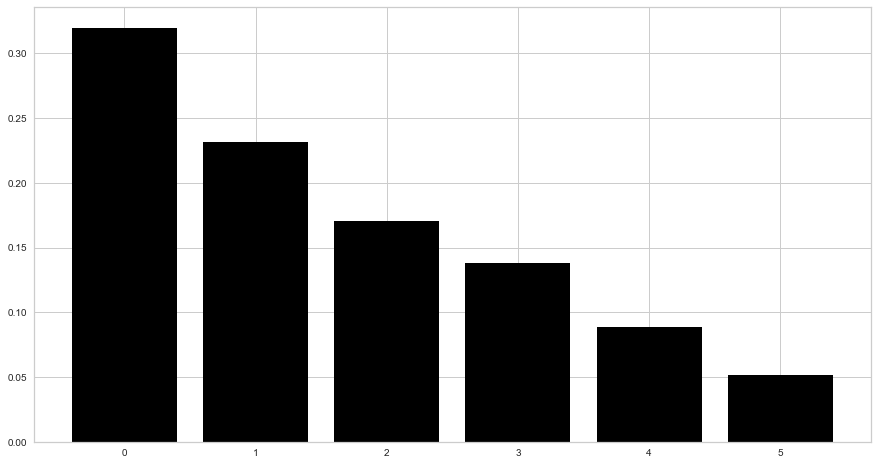

In [126]:

pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color='black')

df_pca=pd.DataFrame(principal_components)

In [127]:
df_pca.head()

,0,1,2,3,4,5
0,-13.625362,15.745673,-5.434397,6.547429,20.803441,0.352583
1,0.947774,-0.913471,0.374898,-0.152037,-0.180302,0.214021
2,2.234299,-0.023902,0.173510,-0.289358,-0.016115,-0.505218
3,0.583774,-0.802582,0.163076,-0.012494,-0.586174,-0.025153
4,-0.476848,0.143578,-0.237922,0.685036,-1.940464,0.097773


<AxesSubplot:xlabel='0', ylabel='1'>

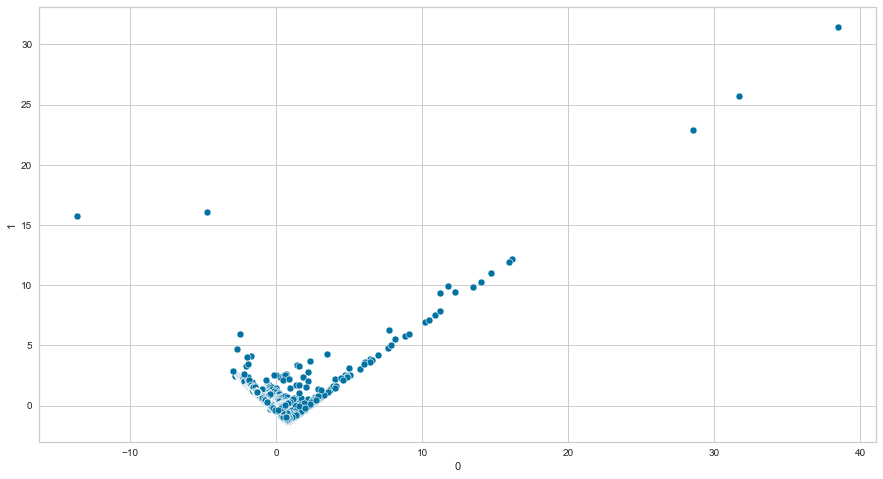

In [128]:
sns.scatterplot(x=0 , y=1, data=df_pca)

## 4.2 Space study - UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

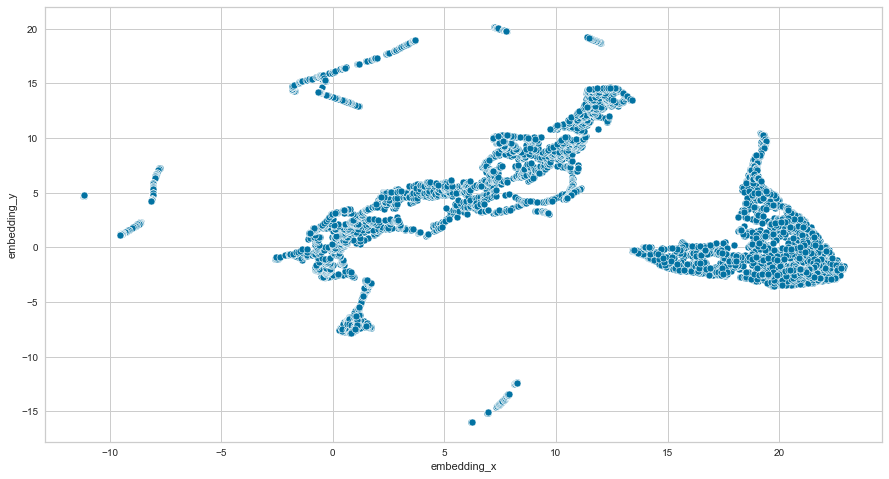

In [129]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x']=embedding[:,0]
df_pca['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_pca)

## 4.3 Space Study - t-SNE

p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

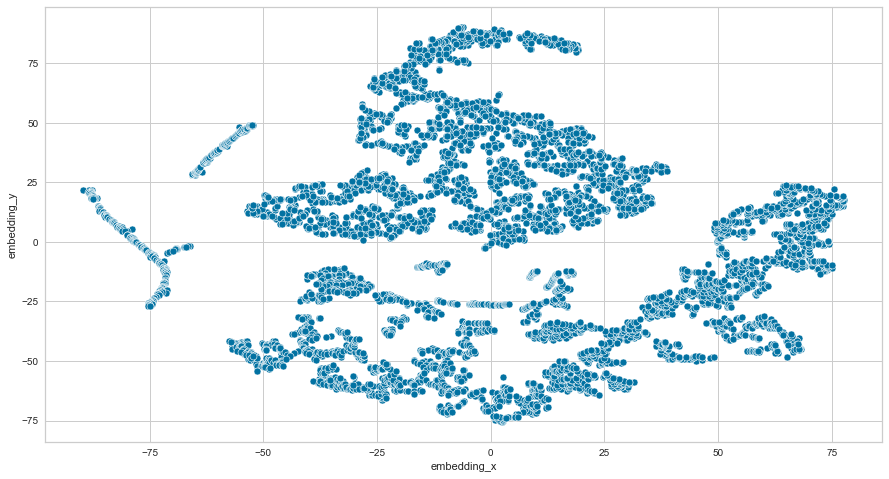

In [130]:
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x']=embedding[:,0]
df_pca['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_pca)

## Space based Tree-Based Embedding

In [131]:
# training dataset

X = df4.drop(['profit','profit'],axis=1)
y = df4['profit']


# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=42)

# model training

rf_model.fit( X, y )

#leaf 

df_leaf = pd.DataFrame(rf_model.apply(X))

p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

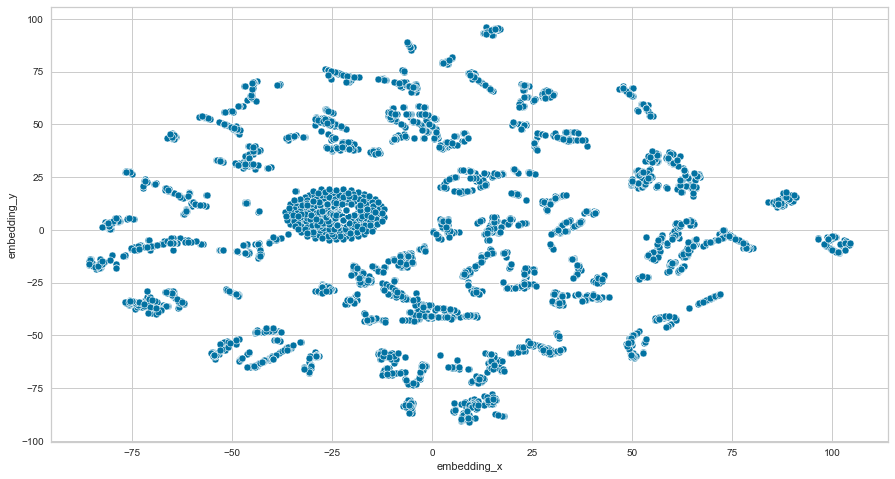

In [132]:
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform( df_leaf )

# embedding
df_leaf['embedding_x']=embedding[:,0]
df_leaf['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_leaf)

## 4.4 Bivariate analysis

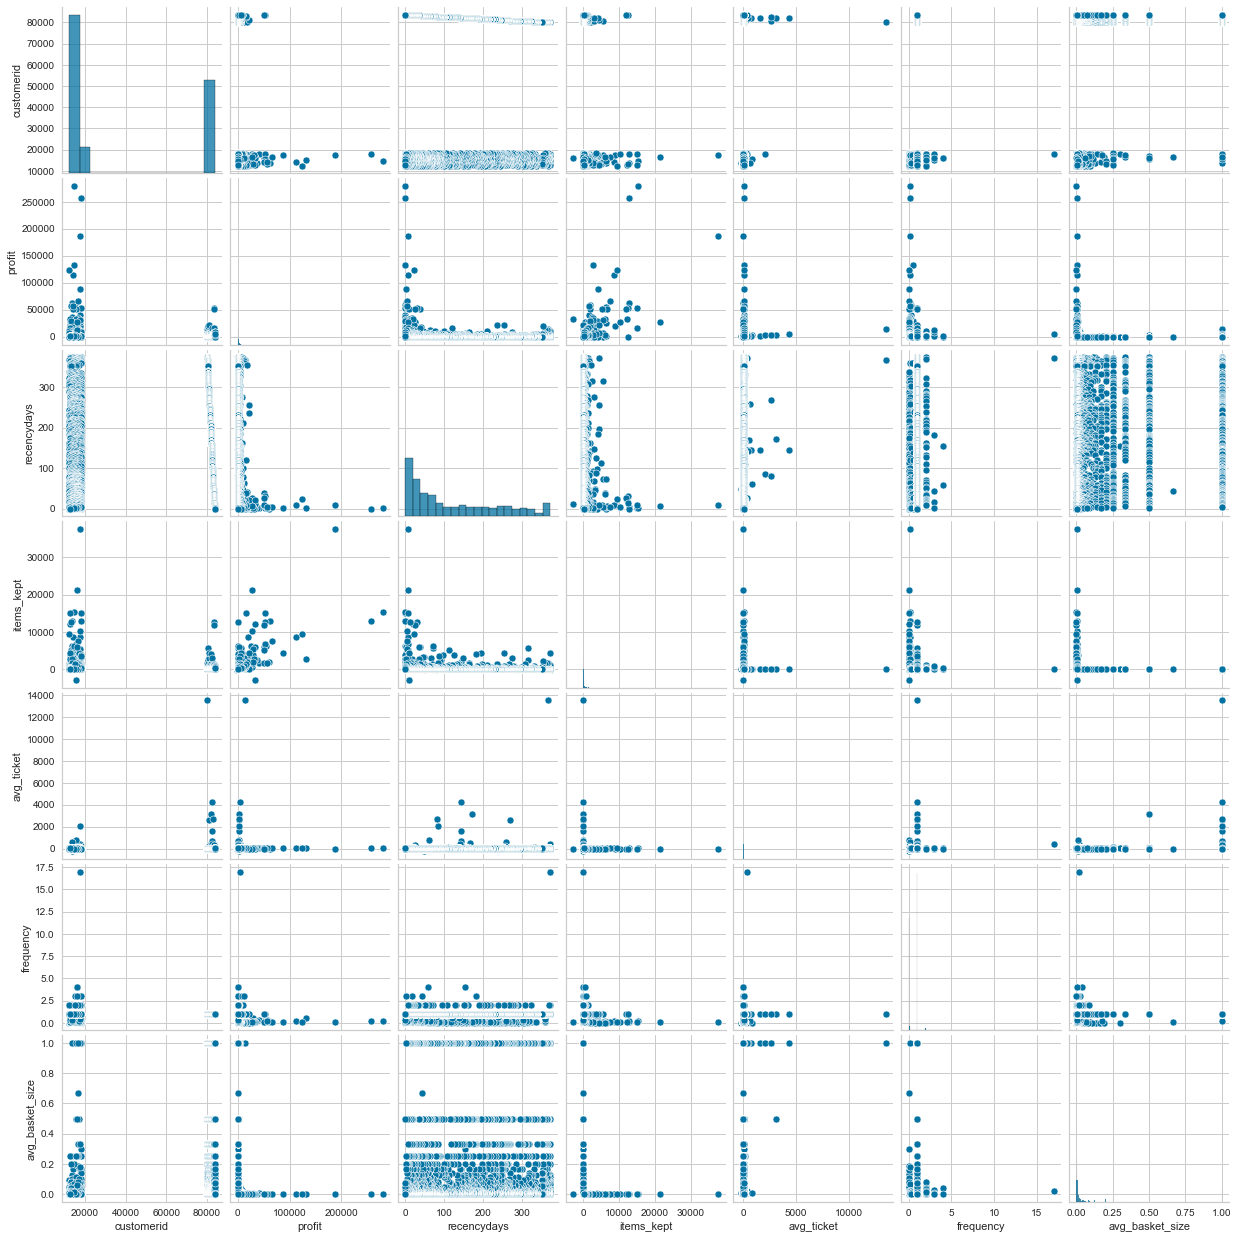

In [133]:
sns.pairplot(df4)
plt.show()

# 5.0 Data Preparation

In [134]:
df5=df4.copy()

In [135]:
df5.columns

Index(['customerid', 'profit', 'recencydays', 'items_kept', 'avg_ticket',
       'frequency', 'avg_basket_size'],
      dtype='object')

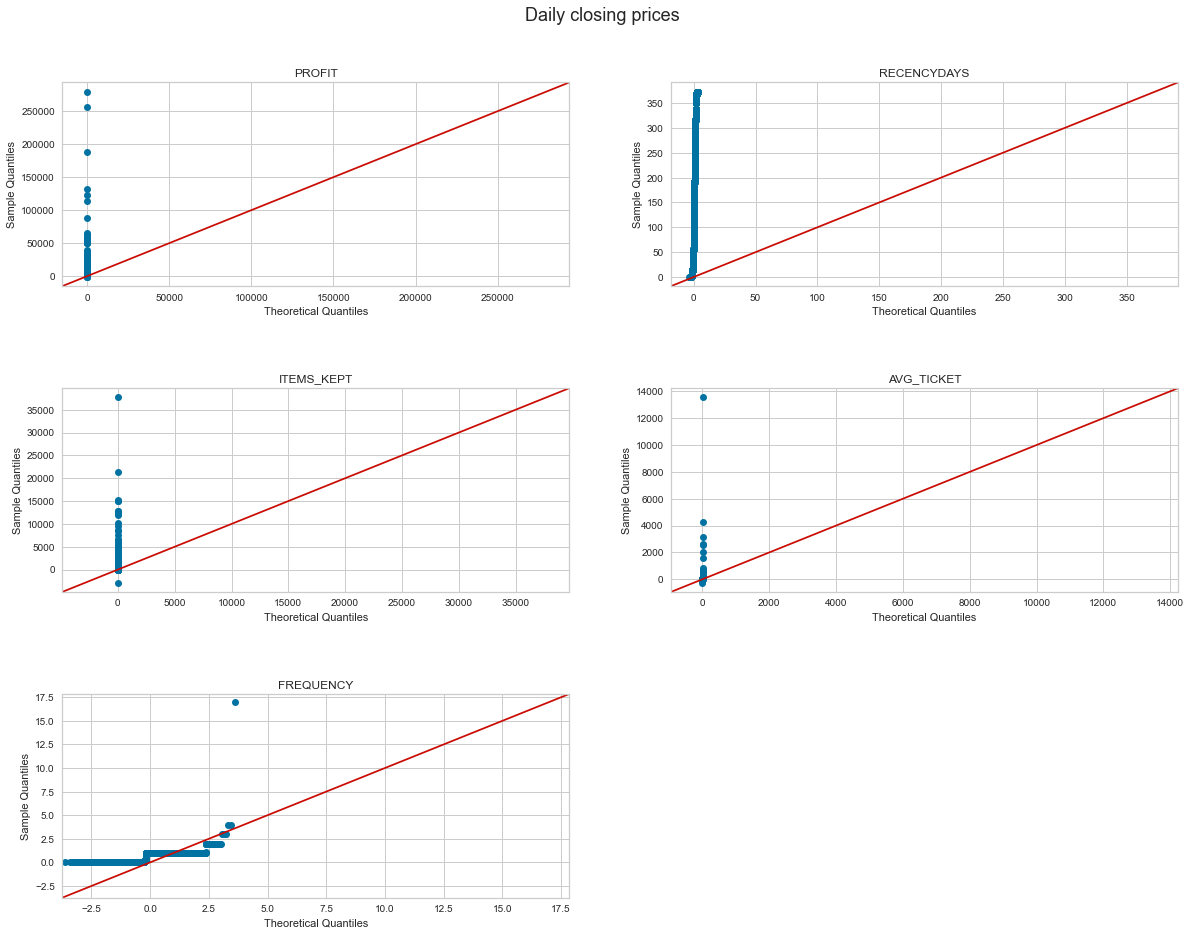

In [169]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

tickers = [ 'profit', 'recencydays', 'items_kept', 'avg_ticket','frequency',]


# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    # filter df and plot ticker on the new subplot axis

    measurements=df4[ticker]
    sm.qqplot(measurements, line='45', ax=ax)
    #pylab.show()

    # chart formatting
    ax.set_title(ticker.upper())
    #ax.get_legend().remove()
    #ax.set_xlabel("")


In [172]:
df4.columns

Index(['customerid', 'profit', 'recencydays', 'items_kept', 'avg_ticket',
       'frequency', 'avg_basket_size'],
      dtype='object')

p:\Anaconda3\envs\automl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\si

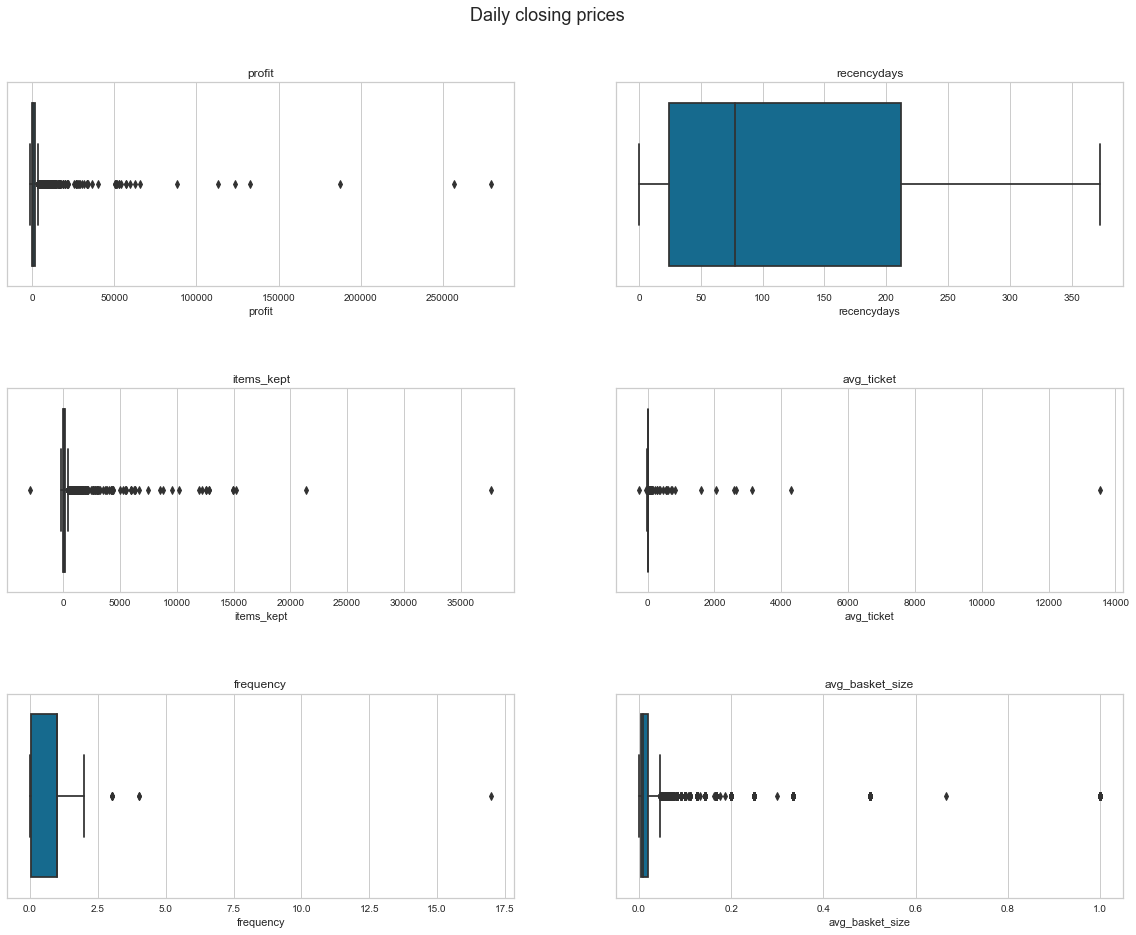

In [177]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

tickers = [ 'profit', 'recencydays', 'items_kept', 'avg_ticket','frequency','avg_basket_size']


# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    # filter df and plot ticker on the new subplot axis

    sns.boxplot(df4[ticker])
    #pylab.show()

    # chart formatting
    ax.set_title(ticker)
    #ax.get_legend().remove()
    #ax.set_xlabel("")


In [178]:

mms=MinMaxScaler()
ss=StandardScaler()
rs=RobustScaler()

mms_cols=['recencydays','frequency']
rs_cols=['profit', 'items_kept','avg_basket_size','avg_ticket']

for i in mms_cols:
    df5[[i]] = mms.fit_transform(df5[[i]])

for i in rs_cols:
    df5[[i]] = rs.fit_transform(df5[[i]])


df5.head()

,customerid,profit,recencydays,items_kept,avg_ticket,frequency,avg_basket_size
0,17850,3.671306,0.997319,-0.430380,40.660467,1.000000,0.716885
1,13047,1.980641,0.083110,0.278481,2.007483,0.001395,-0.027676
2,12583,5.124141,0.005362,9.094937,-0.148293,0.002052,-0.280732
3,13748,0.350180,0.254692,0.550633,-0.052097,0.000734,0.223930
4,15100,0.110567,0.892761,-0.354430,2.006348,0.003985,1.787945


# 6.0 Feature Selection

In [179]:
df6=df5.copy()
cols=['customerid', 'profit', 'recencydays', 'items_kept', 'frequency']
df6=df6[cols]

# 7.0 Hyperparameter Tuning

In [180]:
df7=df6.copy()

In [181]:
X=df6.drop(columns=['customerid'])

In [182]:
clusters= [2, 3, 4, 5, 6, 7, 8, 9]

## 7.1 Within-Cluster Sum of Squares (WSS)

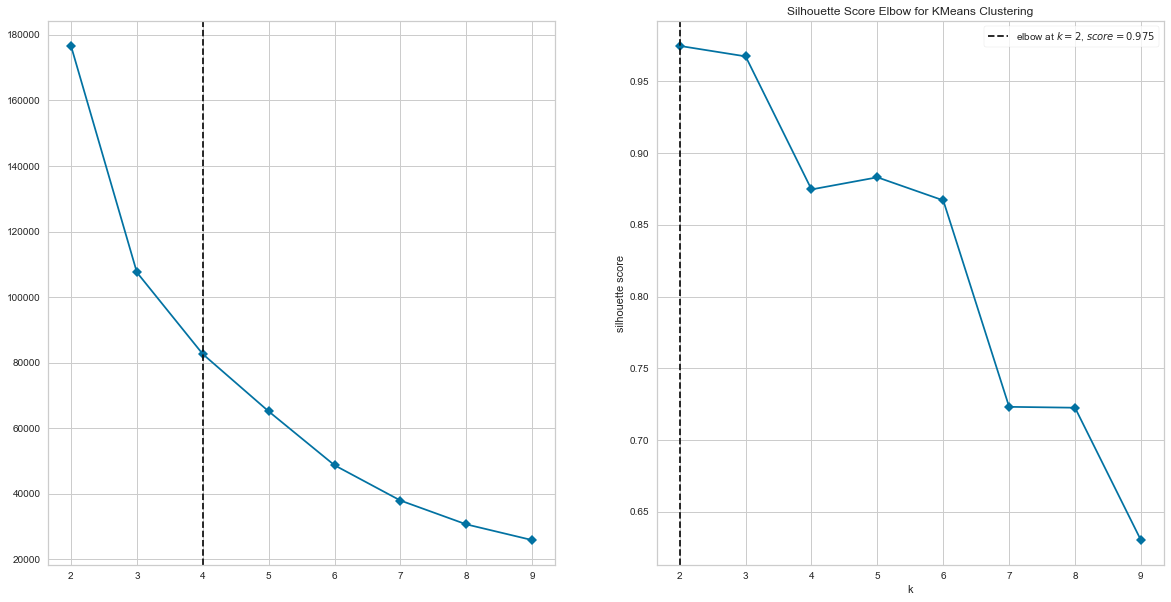

In [183]:
plt.subplot(1,2,1)
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False, metric='distortion')
kmeans.fit(X)


plt.subplot(1,2,2)
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False, metric='silhouette')
kmeans.fit(X)
plt.gcf().set_size_inches(20,10)
kmeans.finalize()

In [206]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

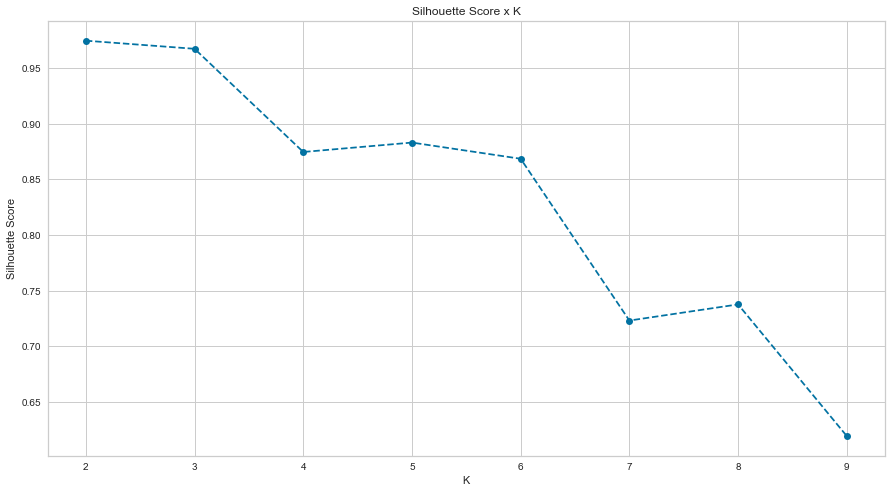

In [207]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2 Silhouette Analysis

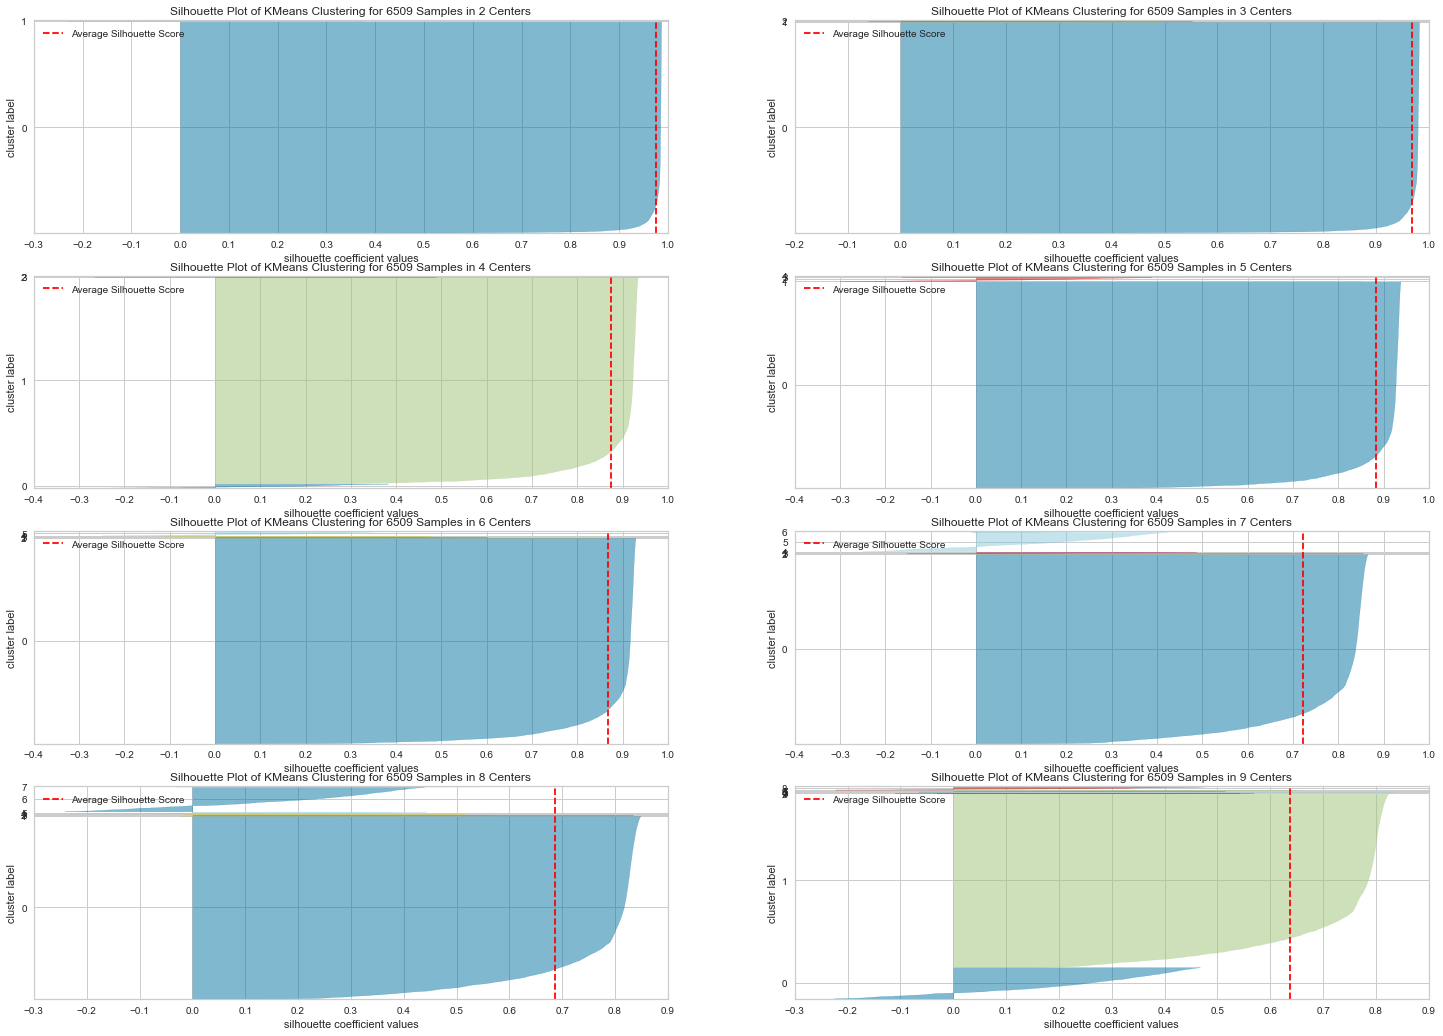

In [184]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette.fit(X)
    vis_silhouette.finalize()

## 7.3 GMM

In [190]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

Text(0.5, 1.0, 'Sil x K')

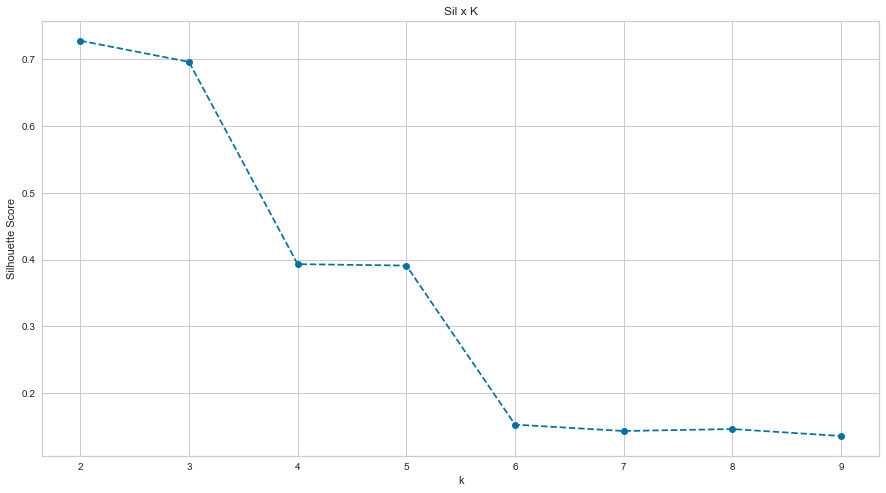

In [191]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k')
plt.ylabel( 'Silhouette Score')
plt.title( 'Sil x K')

## 7.4. HIERARCHICAL CLUSTERING

[]

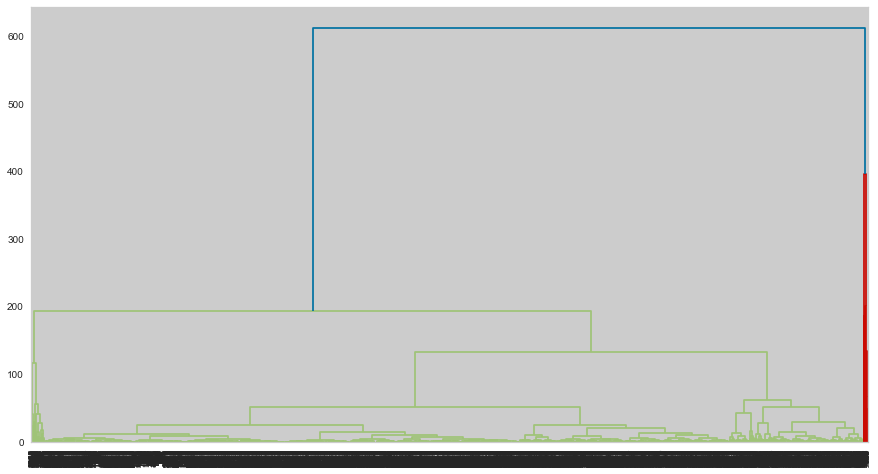

In [195]:
hc_model = hc.linkage( X, 'ward' )
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)
plt.plot()

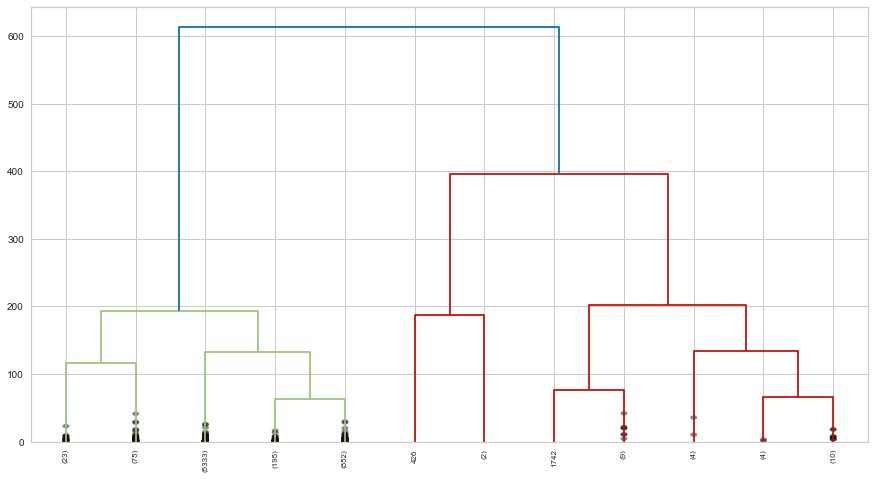

In [196]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

In [197]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

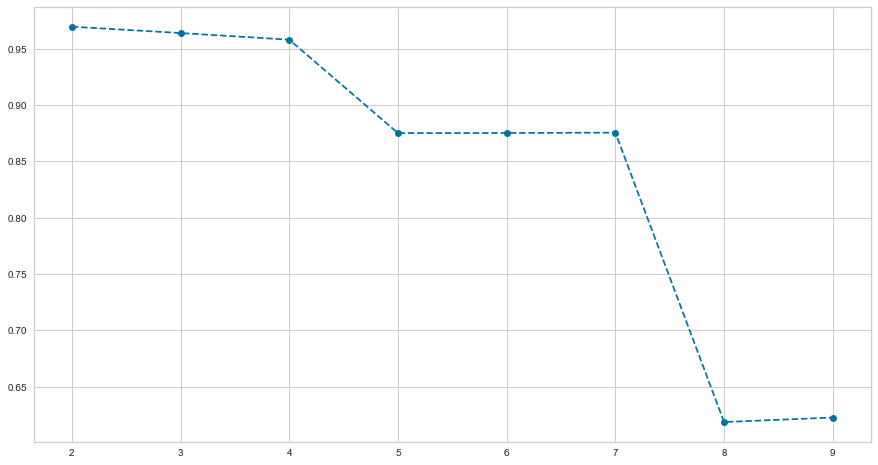

In [198]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' ) 


## 7.5 DBSCAN

In [202]:
eps=[.1, .2, .3, .4, .5]


for i in eps:
# model definition
    dbscan_model = c.DBSCAN( eps=i )

    # mode training & predict 
    labels = dbscan_model.fit_predict( X )

    sil = m.silhouette_score( X, labels, metric='euclidean' )
    print( 'Silhouette Score: {}'.format( sil ) )
    print( 'Number of Clusters: {}'.format( len( np.unique( labels ) ) ) )
    print( np.unique( labels ) )

Silhouette Score: -0.2914759285481062
Number of Clusters: 47
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Silhouette Score: 0.11406605467184508
Number of Clusters: 18
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Silhouette Score: 0.35158829965658667
Number of Clusters: 8
[-1  0  1  2  3  4  5  6]
Silhouette Score: 0.565617069867927
Number of Clusters: 7
[-1  0  1  2  3  4  5]
Silhouette Score: 0.5661877797925207
Number of Clusters: 8
[-1  0  1  2  3  4  5  6]


In [204]:
eps=0.7
for i in np.arange(1,30,5):
    # model definition
    dbscan_model = c.DBSCAN( eps=eps, min_samples=i )

    # mode training & predict 
    labels = dbscan_model.fit_predict( X )

    sil = m.silhouette_score( X, labels, metric='euclidean' )
    print( f'Silhouette Score {sil} , min_samples = {i}' )


Silhouette Score 0.09219350725559786 , min_samples = 1
Silhouette Score 0.7048745309731365 , min_samples = 6
Silhouette Score 0.8755334779754997 , min_samples = 11
Silhouette Score 0.8671819626157701 , min_samples = 16
Silhouette Score 0.8625772104536416 , min_samples = 21
Silhouette Score 0.8511666012365057 , min_samples = 26


In [205]:
# model definition
dbscan_model = c.DBSCAN( eps=0.7, min_samples=26 )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( f'Silhouette Score {sil}')

Silhouette Score 0.8511666012365057


## 7.5 Results


In [214]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list, 
   #  'DBSCAN': dbscan_list
   }
).T

df_results.columns = clusters

In [215]:
df_results.style.highlight_max( color='green', axis=1 ) 

,2,3,4,5,6,7,8,9
KMeans,0.974678,0.967382,0.874679,0.883135,0.868578,0.723209,0.737711,0.619444
GMM,0.728091,0.696304,0.393330,0.391186,0.152956,0.143362,0.146328,0.135844
HC,0.969644,0.964017,0.958116,0.875198,0.875296,0.875583,0.618742,0.622741


# 8.0 Model training

## 8.1 K-Means

In [216]:
# model definition
k=2
kmeans = c.KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)
labels = kmeans.labels_


## 8.2 Cluster Validation

In [217]:
## WSS
print(f"WSS {kmeans.inertia_}")
m.silhouette_score(X,labels,metric='euclidean')

WSS 176643.4016592405


0.9746780180909889

# 9.0 Cluster Analysis

In [220]:
df9=df6.copy()
df9['cluster']=labels
df9.head(2)

,customerid,profit,recencydays,items_kept,frequency,cluster
0,17850,3.671306,0.997319,-0.430380,1.000000,0
1,13047,1.980641,0.083110,0.278481,0.001395,0


## 9.1 Visual Inspection

p:\Anaconda3\envs\automl\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


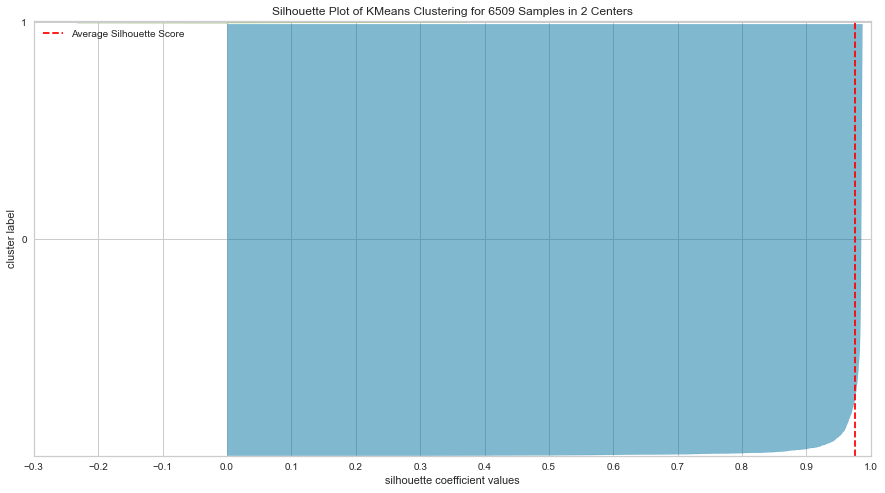

In [221]:
visualizer = SilhouetteVisualizer( kmeans, init='k-means++', colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

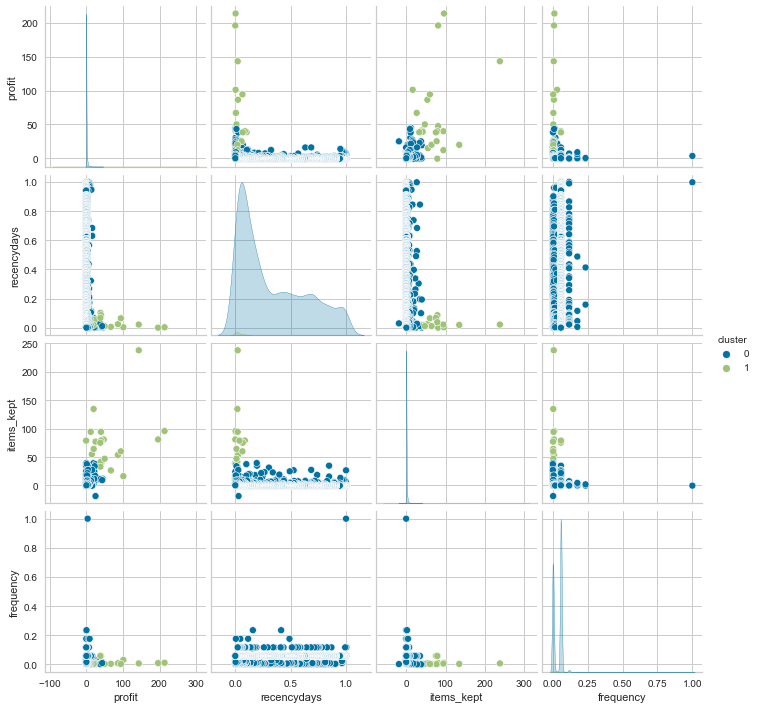

In [222]:
df_viz = df9.drop(columns='customerid',axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP 

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

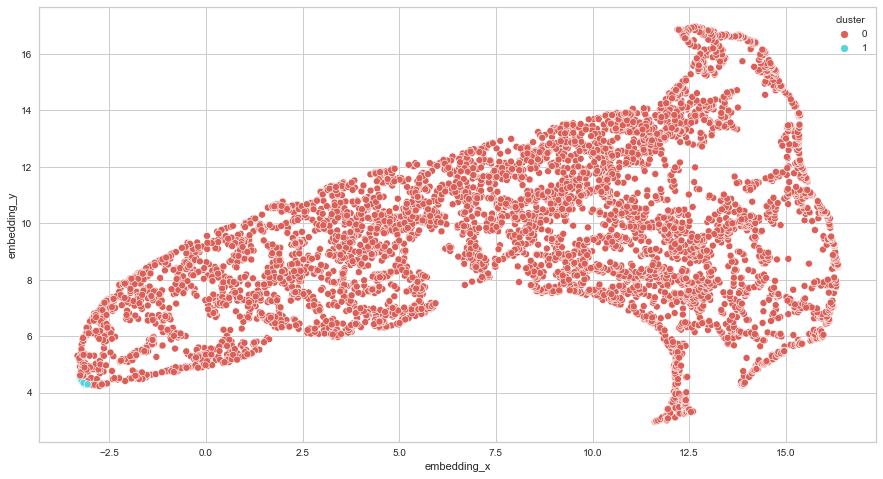

In [223]:
reducer = umap.UMAP(n_neighbors=40, random_state=42)
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x']=embedding[:,0]
df_viz['embedding_y']=embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors= len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.4 Cluster Profile

In [229]:
# Number of customer
df_cluster=df9.groupby(['cluster']).agg({"customerid":"count",
"profit":"mean", "recencydays":"mean" , "items_kept":"mean", "frequency":"mean"})

df_cluster

,customerid,profit,recencydays,items_kept,frequency
cluster,,,,,
0,6487,0.597874,0.330200,0.548822,0.035231
1,22,62.140142,0.027785,72.845512,0.014537


### Cluster 0: - Low Value, Low Frequency, High Recency

### Cluster 1: - Extremely high values, bought every 3 days

### Cluster 2: - High value, but buys at a low frequency and weekly rate

### Cluster 3: - Medium value, Medium frequency, Medium recency
